# UDLF Non-Local Means (RDPAC)
Images and data collected from experiments of UDLF Non-Local Means with RDPAC as the reranking method used.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

%matplotlib inline

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

# Enable relative imports (snippet of code based on https://stackoverflow.com/a/61079434)
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

from nlmeans.nlmeans import nlmeans
from nlmeans.nlmeans_udlf import nlmeans_udlf

from parameters import *
from utils import *

## Parameters

In [2]:
udl_method = 'RDPAC'
udl_params = get_udl_params(udl_method)
print(udl_method, udl_params)

RDPAC {'k_end': 15, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}


In [3]:
parent_dir = os.path.join(dir1, 'output', 'final_tests', f'{udl_method}_{seed}')
if save_data:
    from pathlib import Path
    out_dir = os.path.join(parent_dir, shape)
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    print(out_dir)

./output/final_tests/RDPAC_42/disk


## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

<Figure size 640x480 with 0 Axes>

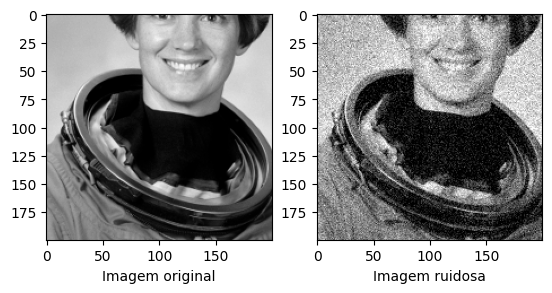

In [4]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

plt.set_cmap('gray')
plt.figure()

plt.subplot(1, 2, 1)
plt.xlabel('Imagem original')
plt.imshow(im)

plt.subplot(1, 2, 2)
plt.xlabel('Imagem ruidosa')
plt.imshow(im_nse)
plt.show()

## Non-Local Means SAP
For comparison the Non-Local Means SAP (the algorithm on which UDLF Non-Local Means is based) is run as well. 

CPU times: user 1.69 s, sys: 5.72 ms, total: 1.69 s
Wall time: 1.69 s


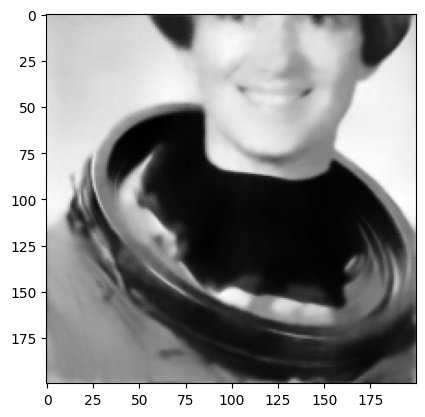

In [5]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
plt.imshow(im_fil1, cmap='gray')

## UDLF Non-Local Means (NONE)
The results of the reranking method will be compared with Non-Local Means using the original ranked lists, that is, the ranked lists used as input to UDLF. 

CPU times: user 10.7 s, sys: 779 ms, total: 11.4 s
Wall time: 11.5 s


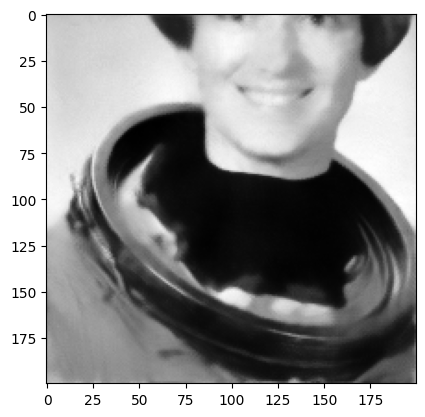

In [6]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()
plt.imshow(im_fil3, cmap='gray')

## UDLF Non-Local Means (RDPAC)
This denoise the image using RDPAC as the reranking method.

CPU times: user 11.7 s, sys: 848 ms, total: 12.5 s
Wall time: 4min 32s


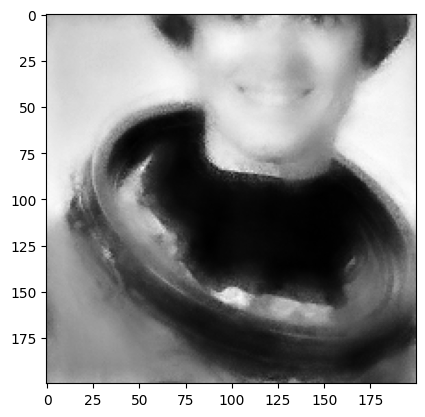

In [7]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()
plt.imshow(im_fil2, cmap='gray')

### Show the images side by side

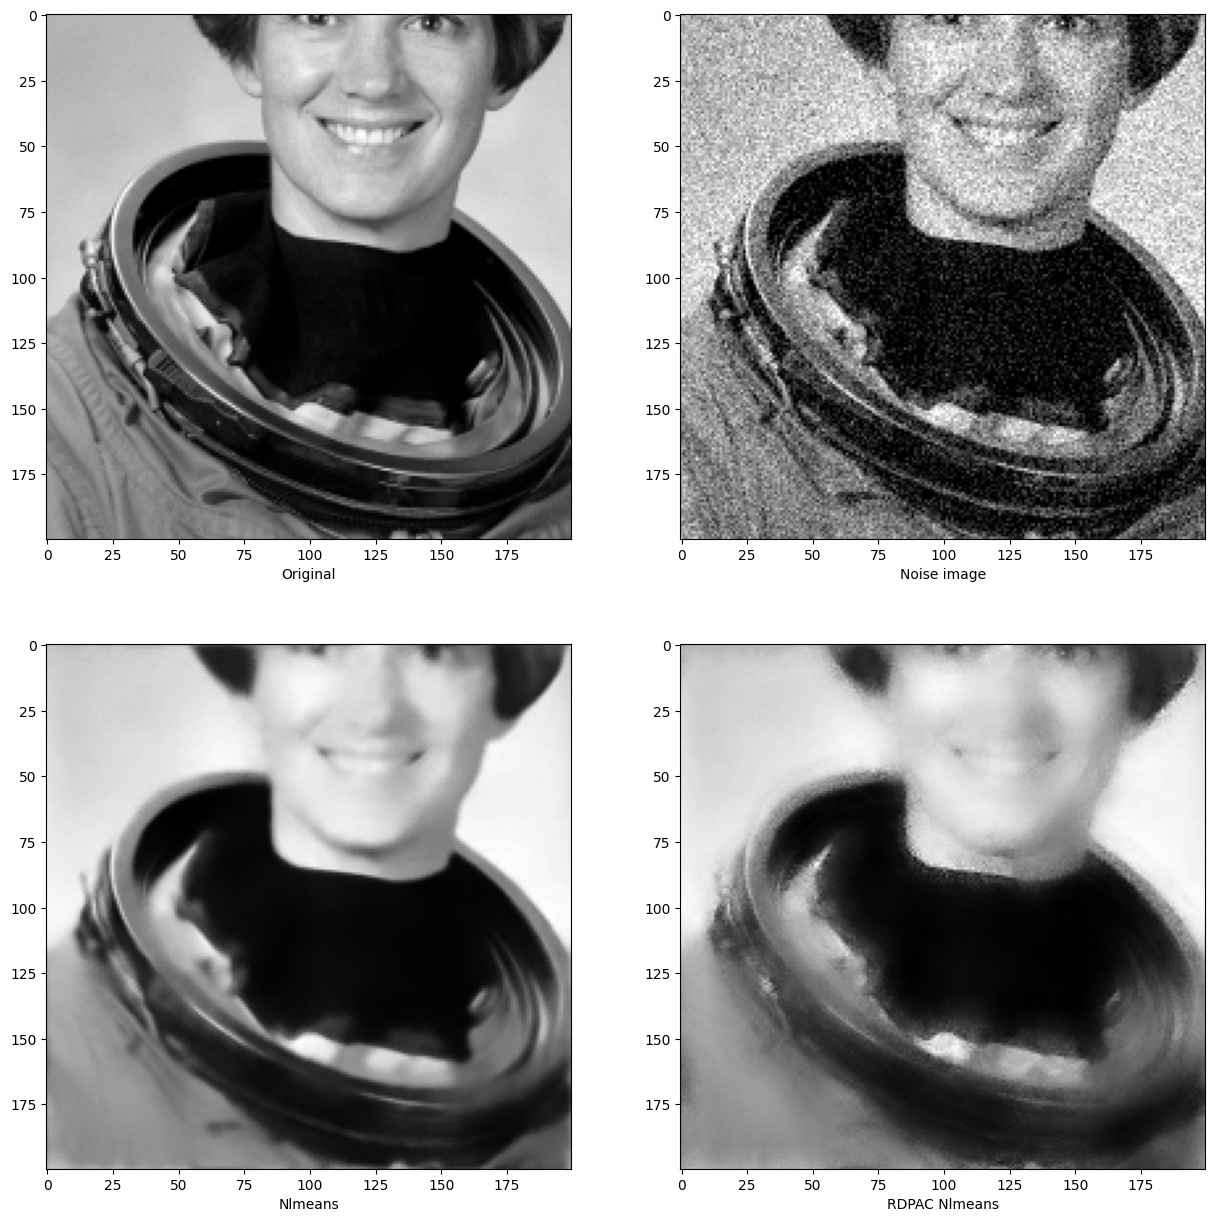

Noise    Nlmeans  RDPAC Nlmeans  NONE Nlmeans
PSNR  20.582626  23.142633      20.043952     23.327438
SSIM   0.450165   0.679699       0.546412      0.687343
MSE    0.008745   0.003362       0.006677      0.003233

In [8]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse)
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1)
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(im_fil2)
plt.show()

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

# Updates the figure size
plt.rcParams['figure.figsize'] = [15, 5]

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

The parameters found for the first image will be used for the experiments in all the other images.

### K End

In [9]:
%%time
start    = 3
end      = 21
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
psnr_max = 0
best_k_end = start
best_im  = None

for i, k_end in enumerate(possible_values):
    udl_params['k_end'] = k_end
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        print(udl_params, psnr_value, sep='\t')
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_k_end = k_end
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k_end)
        break
        
# Update method parameters
udl_params['k_end'] = best_k_end
print('\nFinal params:')
print(udl_params, psnr_max, sep='\t')

{'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	20.48945726838817
{'k_end': 4, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	20.11844086718501
{'k_end': 5, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	20.061235235184178
{'k_end': 6, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	20.15782271408579
{'k_end': 7, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	19.97936119906113
{'k_end': 8, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	19.97527287927697
{'k_end': 9, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	19.96604395623904
{'k_end': 10, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	20.047678555659463
{'k_end': 11, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	19.991888219794482
{'k_end': 12, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	19.94472877294131
{'k_end': 13, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 

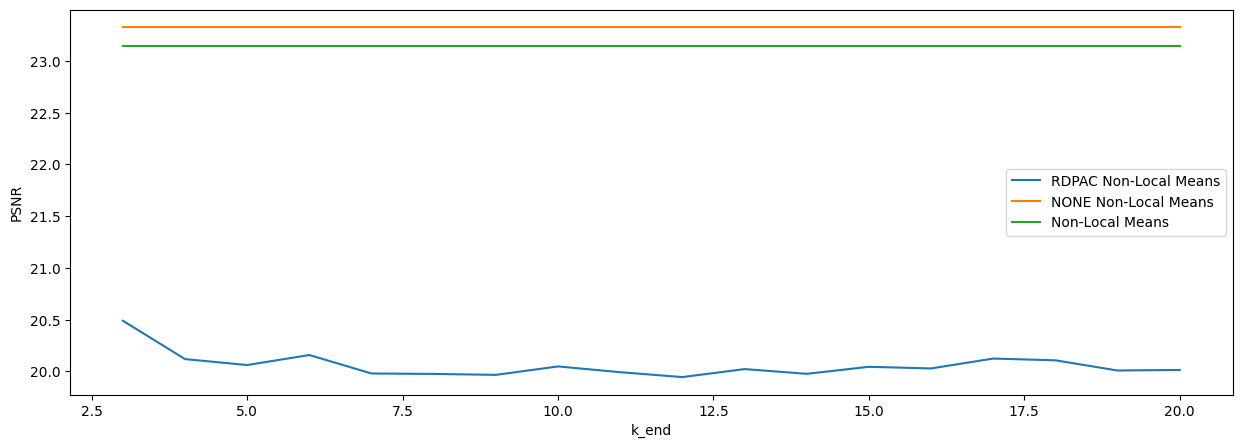

In [10]:
udlf_plot, = plt.plot(possible_values, psnrs, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('k_end')
plt.ylabel('PSNR')
if save_data:
    plt.savefig(os.path.join(out_dir, 'k_end_tuning_plot.png'))

### L Multiplier

In [11]:
%%time
start    = 1
end      = 5
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
psnr_max = 0
best_l_mult = start
best_im  = None

for i, l_mult in enumerate(possible_values):
    udl_params['l_mult'] = l_mult
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        print(udl_params, psnr_value, sep='\t')
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_l_mult = l_mult
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['l_mult'] = best_l_mult
print('\nFinal params:')
print(udl_params, psnr_max, sep='\t')

{'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	20.48945726838817
{'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 2, 'p': 0.75, 'pl': 0.97}	12.03846135467389
{'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 3, 'p': 0.75, 'pl': 0.97}	9.725094724443007
{'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 4, 'p': 0.75, 'pl': 0.97}	9.639501914358302

Final params:
{'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	20.48945726838817
CPU times: user 51.6 s, sys: 3.37 s, total: 55 s
Wall time: 7min 8s


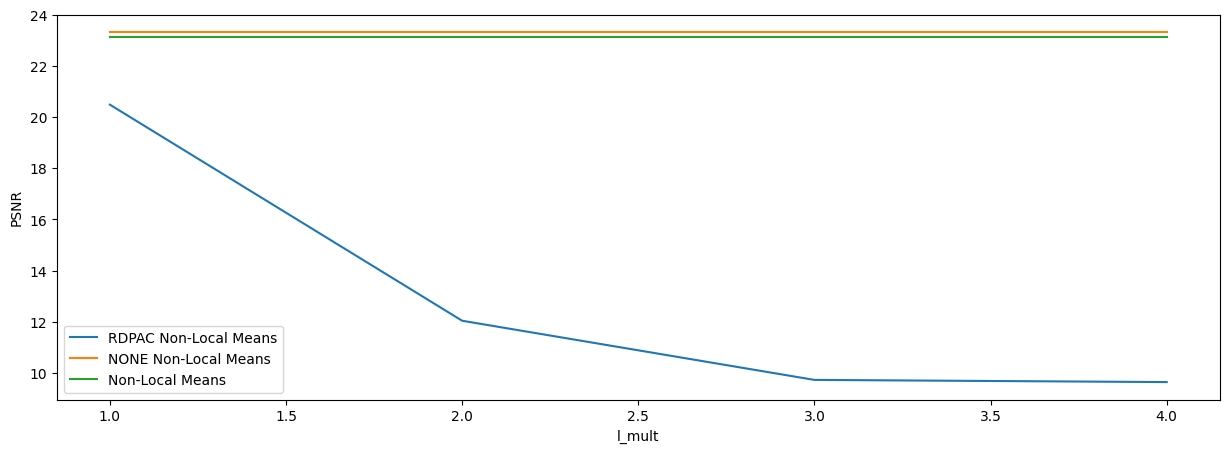

In [12]:
udlf_plot, = plt.plot(possible_values, psnrs, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('l_mult')
plt.ylabel('PSNR')
if save_data:
    plt.savefig(os.path.join(out_dir, 'l_mult_tuning_plot.png'))

### Final Result

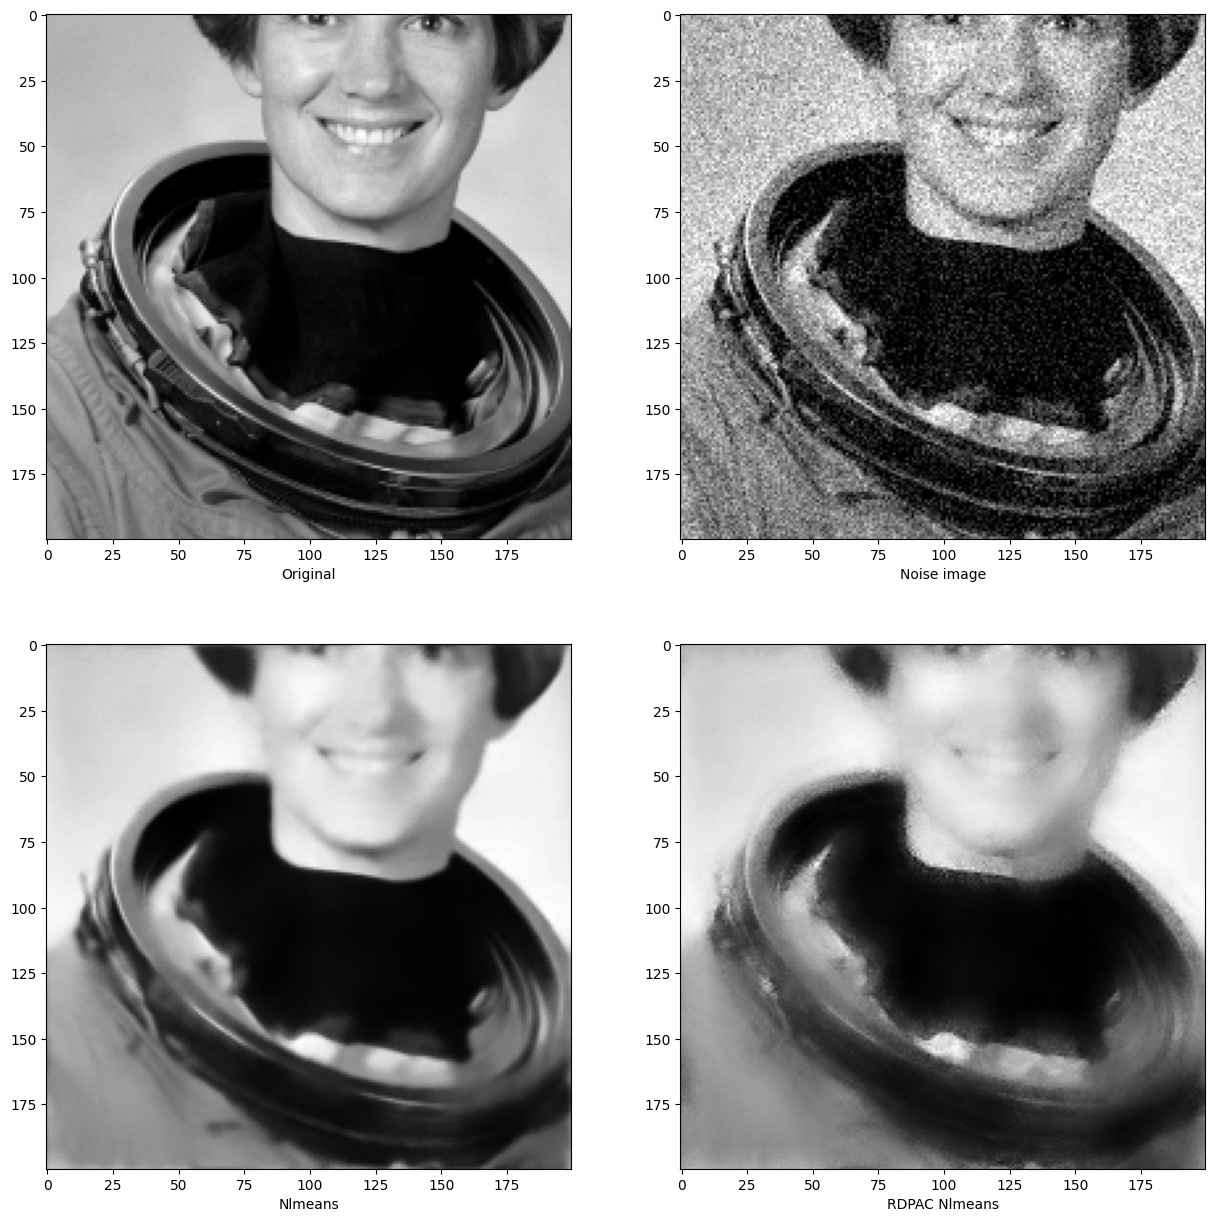

Noise    Nlmeans  RDPAC Nlmeans  NONE Nlmeans
PSNR  20.582626  23.142633      20.043952     23.327438
SSIM   0.450165   0.679699       0.546412      0.687343
MSE    0.008745   0.003362       0.006677      0.003233

In [13]:
#im_fil2 = best_im
best_im = im_fil2

plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(best_im, cmap='gray')
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

# Recalculates for UDLF
im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)

## Experiments with other images
Given the images tuple containing a subset of the images in skimage.data, denoise will be made in all these images to compare in the end if the UDLF Non-Local Means algorithm was positive in all of them. 

In [14]:
%%time
import sys

eval_info = []
eval_psnr = []
eval_ssim = []
images_tested = []
print('Method:', udl_method)
print('Parameters:', udl_params)

for image in images:
    im, im_name = get_image(image)
    im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

    # In case of error, the functions above return None
    if im is None:
        continue
    
    ## Nlmeans
    im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

    ## UDLF Nlmeans
    im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
    rm_tmp_files()
    
    ## NONE Nlmeans
    im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
    rm_tmp_files() 
    
    # Save the images if requested
    if save_data:
        plt.imsave(os.path.join(out_dir, f'{image}.png'), im)
        plt.imsave(os.path.join(out_dir, f'{image}_noise.png'), im_nse)
        plt.imsave(os.path.join(out_dir, f'{image}_nlm.png'), im_fil1)
        plt.imsave(os.path.join(out_dir, f'{image}_{udl_method}.png'), im_fil2)
        plt.imsave(os.path.join(out_dir, f'{image}_NONE.png'), im_fil3)

    # Evaluation
    im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
    im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
    im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
    im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)
    
    eval_info.append([im_noise_psnr, im_noise_ssim, im_noise_mse,
                      im_nlm_psnr, im_nlm_ssim, im_nlm_mse,
                      im_udlf_psnr, im_udlf_ssim, im_udlf_mse,
                      im_none_psnr, im_none_ssim, im_none_mse])
    
    eval_psnr.append([im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr])
    
    eval_ssim.append([im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim])
    
    images_tested.append(image)
    print('Tested with image:', image, im.shape)

Method: RDPAC
Parameters: {'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}
Tested with image: astronaut (200, 200)
Tested with image: binary_blobs (200, 200)
Tested with image: brick (200, 200)
Tested with image: camera (200, 200)
Tested with image: cat (200, 200)
Tested with image: checkerboard (200, 200)
Tested with image: clock (200, 200)
Tested with image: coffee (200, 200)
Tested with image: coins (200, 200)
Tested with image: eagle (200, 200)
Tested with image: grass (200, 200)
Tested with image: gravel (200, 200)
Tested with image: horse (200, 200)
Tested with image: page (191, 191)
Tested with image: text (172, 172)
Tested with image: rocket (200, 200)
CPU times: user 5min 38s, sys: 19.4 s, total: 5min 57s
Wall time: 25min 58s


### Results

In [15]:
results_psnr_df = pd.DataFrame(
    data = eval_psnr,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params, 'PSNR')
print('Number of images tested:', len(images_tested))
results_psnr_df.style.apply(highlight_best_values, axis=1)

RDPAC {'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97} PSNR
Number of images tested: 16


In [16]:
results_ssim_df = pd.DataFrame(
    data = eval_ssim,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params, 'SSIM')
print('Number of images tested:', len(images_tested))
results_ssim_df.style.apply(highlight_best_values, axis=1)

RDPAC {'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97} SSIM
Number of images tested: 16


In [17]:
results_psnr_df[results_psnr_df['RDPAC'] > results_psnr_df['Nlmeans']]

Empty DataFrame
Columns: [Noise, Nlmeans, RDPAC, NONE]
Index: []

In [18]:
results_ssim_df[results_ssim_df['RDPAC'] > results_ssim_df['Nlmeans']]

Empty DataFrame
Columns: [Noise, Nlmeans, RDPAC, NONE]
Index: []

In [19]:
if save_data:
    import json
    results_psnr_df.to_csv(os.path.join(out_dir, 'results_psnr.csv'))
    results_ssim_df.to_csv(os.path.join(out_dir, 'results_ssim.csv'))
    with open(os.path.join(out_dir, 'params.json'), 'w') as fp:
        json.dump({
            'hP': hP,
            'hW': hW,
            'tau': tau,
            'sig': sig,
            'shape': shape,
            'n_w': n_w,
            'seed': seed,
            'udl_method': udl_method,
            'udl_params': udl_params,
            'tuning_method': 'simple'
        }, fp)

# Experiments with 'square' shape

## Parameters

In [20]:
image = 'astronaut'
shape = 'square'
udl_params = get_udl_params(udl_method)
print(udl_method, udl_params)

RDPAC {'k_end': 15, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}


In [21]:
if save_data:
    from pathlib import Path
    out_dir = os.path.join(parent_dir, shape)
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    print(out_dir)

./output/final_tests/RDPAC_42/square


## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

In [22]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

## Initial execution

Executes the original NLM, NLM-UDLF and NLM-NONE for the image, only changing the shape parameter.

In [23]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


In [24]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()

CPU times: user 10.8 s, sys: 607 ms, total: 11.4 s
Wall time: 11.4 s


In [25]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()

CPU times: user 15.5 s, sys: 1.05 s, total: 16.6 s
Wall time: 5min 31s


### Initial result

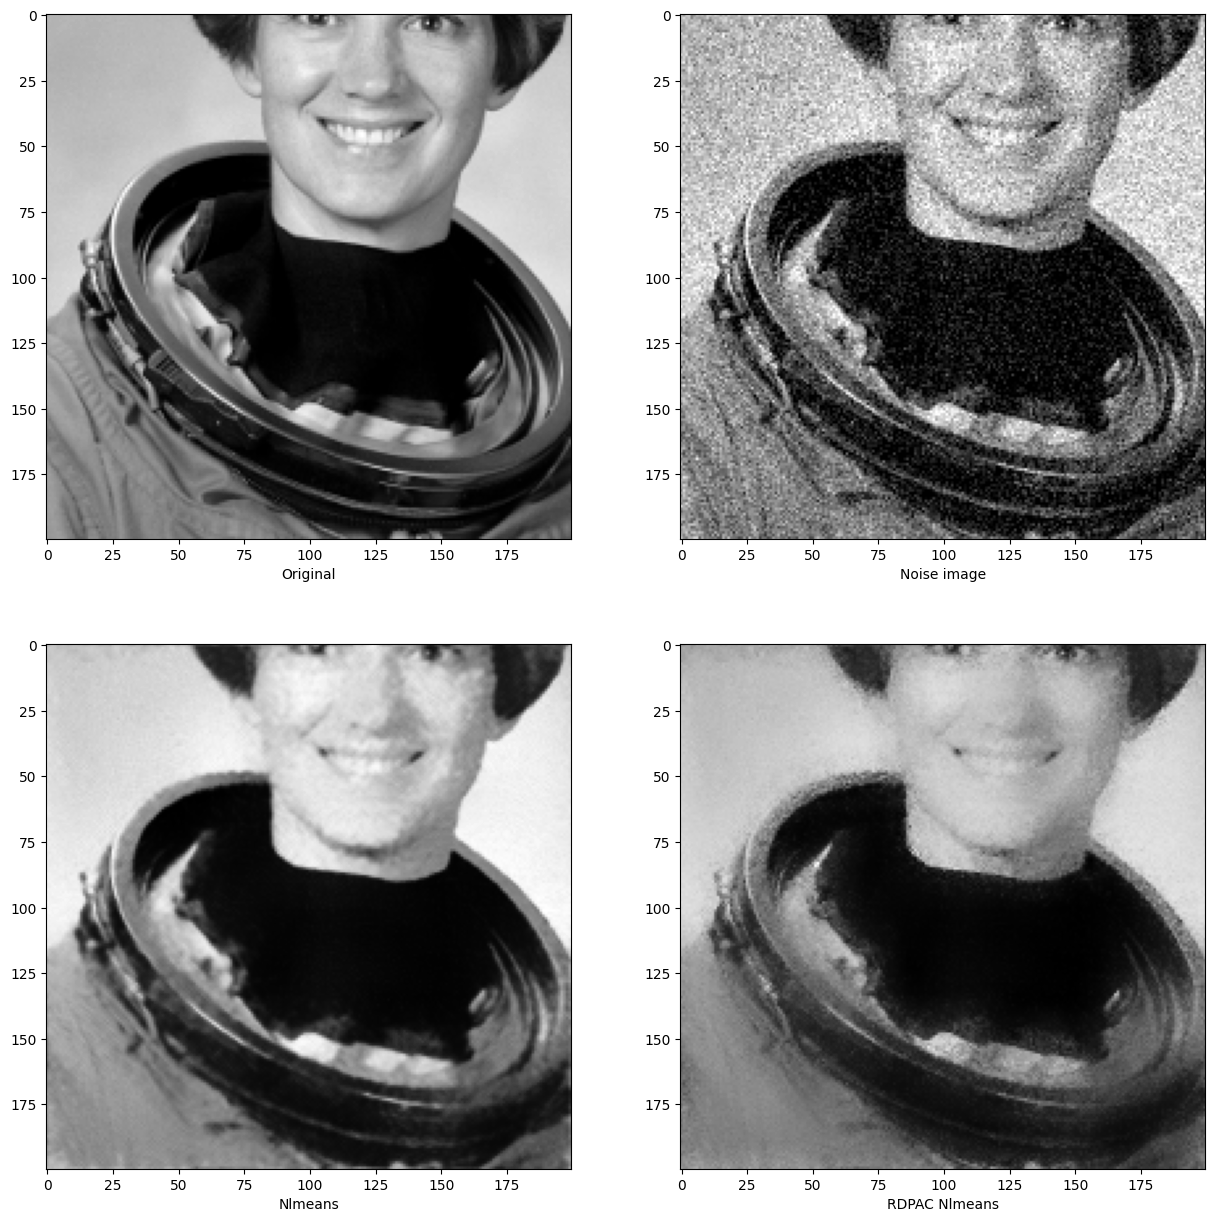

Noise    Nlmeans  RDPAC Nlmeans  NONE Nlmeans
PSNR  20.582626  24.478626      22.120150     24.560339
SSIM   0.450165   0.720574       0.618660      0.705158
MSE    0.008745   0.002515       0.005159      0.002504

In [26]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse)
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1)
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(im_fil2)
plt.show()

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

# Updates the figure size
plt.rcParams['figure.figsize'] = [15, 5]

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)

## Hyperparameters Tuning
The last experiment was runned using the default parameters which can be not the best. The next section tries to find the best value to each of the parameters accepted by the reranking method.

All the tests will be made considering PSNR as the value to be maximized.

The parameters found for the first image will be used for the experiments in all the other images.

### K End

In [27]:
%%time
start    = 3
end      = 22
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
psnr_max = 0
best_k_end = start
best_im  = None

for i, k_end in enumerate(possible_values):
    udl_params['k_end'] = k_end
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        print(udl_params, psnr_value, sep='\t')
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_k_end = k_end
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k_end)
        break
        
# Update method parameters
udl_params['k_end'] = best_k_end
print('\nFinal params:')
print(udl_params, psnr_max, sep='\t')

{'k_end': 3, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	21.68335505736057
{'k_end': 4, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	21.827898206291408
{'k_end': 5, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	21.923061687576265
{'k_end': 6, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	21.94262004923271
{'k_end': 7, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	21.616289399846032
{'k_end': 8, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	21.646942104617814
{'k_end': 9, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	21.854085843404167
{'k_end': 10, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	21.711599069287637
{'k_end': 11, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	21.933125146225542
{'k_end': 12, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	22.053718332885808
{'k_end': 13, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0

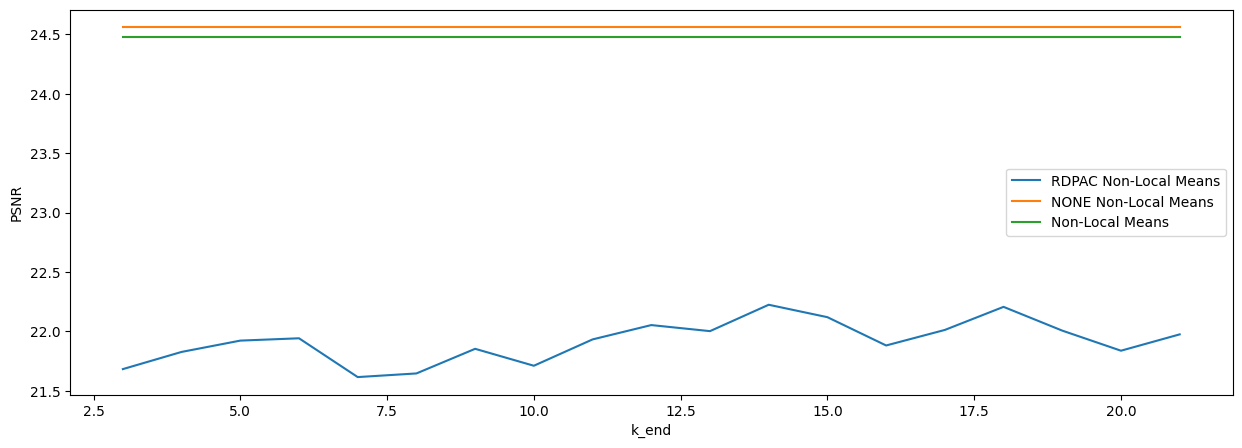

In [28]:
udlf_plot, = plt.plot(possible_values, psnrs, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('k_end')
plt.ylabel('PSNR')
if save_data:
    plt.savefig(os.path.join(out_dir, 'k_end_tuning_plot.png'))

### L Multiplier

In [29]:
%%time
start    = 1
end      = 5
step     = 1
possible_values = range(start, end, step)
iter_num = len(possible_values)
psnrs    = np.zeros(iter_num)
psnr_max = 0
best_l_mult = start
best_im  = None

for i, l_mult in enumerate(possible_values):
    udl_params['l_mult'] = l_mult
    try:
        im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
        rm_tmp_files()
        psnr_value = psnr(im, im_fil3, data_range=im_fil3.max() - im_fil3.min())
        print(udl_params, psnr_value, sep='\t')
        if psnr_value > psnr_max:
            psnr_max = psnr_value
            best_l_mult = l_mult
            best_im  = im_fil3
        psnrs[i] = psnr_value
    except:
        print('Finished with error on param:', k)
        break
        
# Update method parameters
udl_params['l_mult'] = best_l_mult
print('\nFinal params:')
print(udl_params, psnr_max, sep='\t')

{'k_end': 14, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	22.22464114306174
{'k_end': 14, 'k_inc': 1, 'k_start': 1, 'l_mult': 2, 'p': 0.75, 'pl': 0.97}	10.300704230844024
{'k_end': 14, 'k_inc': 1, 'k_start': 1, 'l_mult': 3, 'p': 0.75, 'pl': 0.97}	9.399733289679848
{'k_end': 14, 'k_inc': 1, 'k_start': 1, 'l_mult': 4, 'p': 0.75, 'pl': 0.97}	9.359652229618517

Final params:
{'k_end': 14, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}	22.22464114306174
CPU times: user 1min 4s, sys: 4.58 s, total: 1min 9s
Wall time: 13min 3s


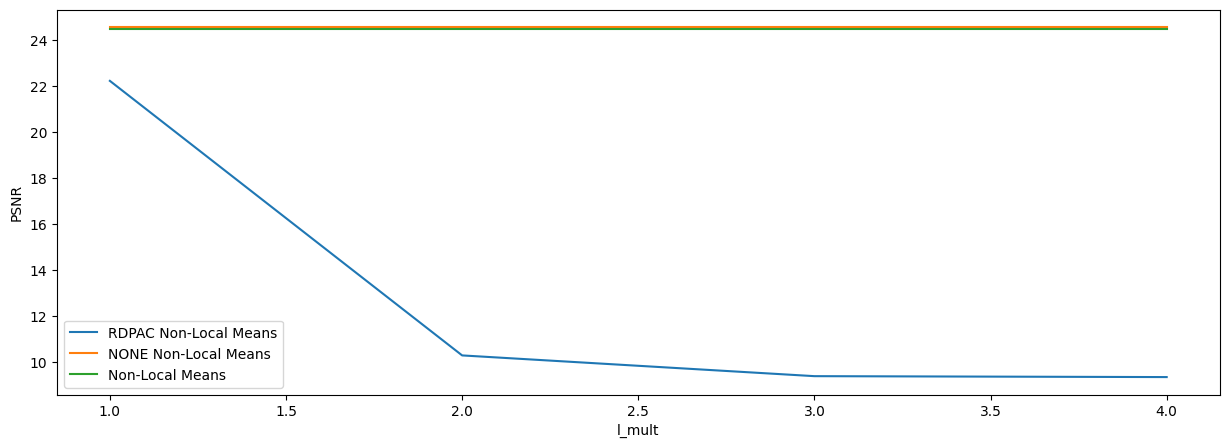

In [30]:
udlf_plot, = plt.plot(possible_values, psnrs, label = f'{udl_method} Non-Local Means')
none_plot, = plt.plot(possible_values, [im_none_psnr] * iter_num, label = 'NONE Non-Local Means')
nlm_plot,  = plt.plot(possible_values, [im_nlm_psnr] * iter_num, label = 'Non-Local Means')
plt.legend(handles = [udlf_plot, none_plot, nlm_plot])
plt.xlabel('l_mult')
plt.ylabel('PSNR')
if save_data:
    plt.savefig(os.path.join(out_dir, 'l_mult_tuning_plot.png'))

### Final Result

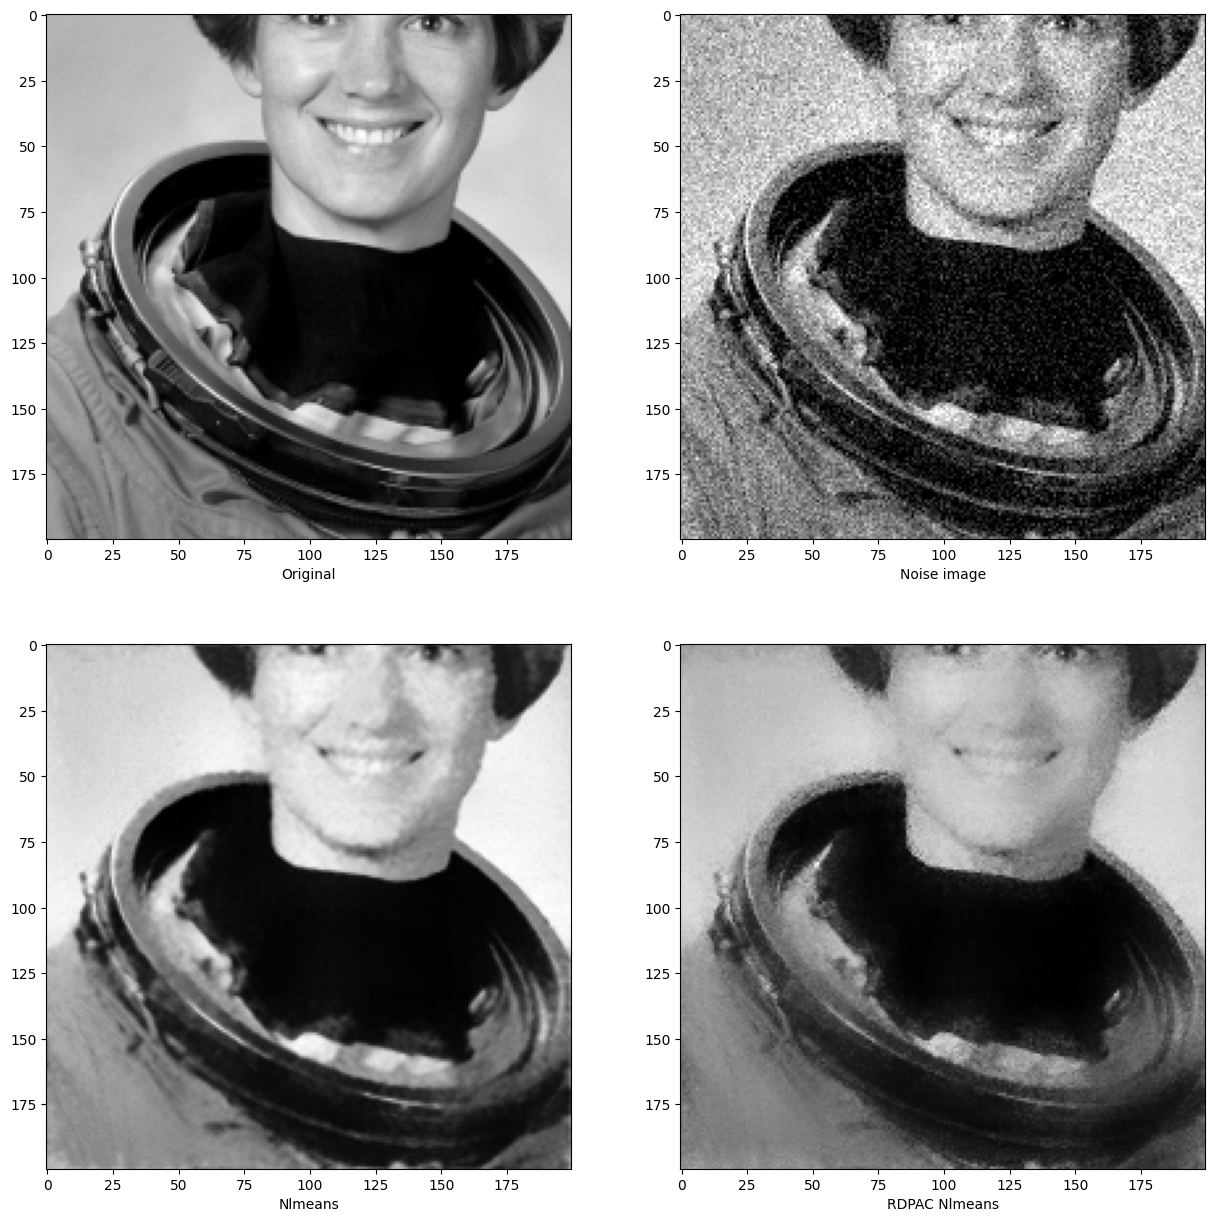

Noise    Nlmeans      RDPAC       NONE
PSNR  20.582626  24.478626  22.224641  24.560339
SSIM   0.450165   0.720574   0.620129   0.705158
MSE    0.008745   0.002515   0.005174   0.002504

In [31]:
im_fil2 = best_im

plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im, cmap='gray')
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse, cmap='gray')
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1, cmap='gray')
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(best_im, cmap='gray')
plt.show()

# Updates the figsize
plt.rcParams['figure.figsize'] = [15, 5]

# Recalculates for UDLF
im_udlf_psnr  = psnr(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_ssim  = ssim(im, im_fil2, data_range=im_fil2.max() - im_fil2.min())
im_udlf_mse   = mse(im, im_fil2)

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE'],
)

## Experiments with other images
Given the images tuple containing a subset of the images in skimage.data, denoise will be made in all these images to compare in the end if the UDLF Non-Local Means algorithm was positive in all of them. 

In [32]:
%%time
import sys

eval_info = []
eval_psnr = []
eval_ssim = []
images_tested = []
print('Method:', udl_method)
print('Parameters:', udl_params)

for image in images:
    im, im_name = get_image(image)
    im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

    # In case of error, the functions above return None
    if im is None:
        continue
    
    ## Nlmeans
    im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)

    ## UDLF Nlmeans
    im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
    rm_tmp_files()
    
    ## NONE Nlmeans
    im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
    rm_tmp_files() 
    
    # Save the images if requested
    if save_data:
        plt.imsave(os.path.join(out_dir, f'{image}.png'), im)
        plt.imsave(os.path.join(out_dir, f'{image}_noise.png'), im_nse)
        plt.imsave(os.path.join(out_dir, f'{image}_nlm.png'), im_fil1)
        plt.imsave(os.path.join(out_dir, f'{image}_{udl_method}.png'), im_fil2)
        plt.imsave(os.path.join(out_dir, f'{image}_NONE.png'), im_fil3)

    # Evaluation
    im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
    im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
    im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
    im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

    eval_info.append([im_noise_psnr, im_noise_ssim, im_noise_mse,
                      im_nlm_psnr, im_nlm_ssim, im_nlm_mse,
                      im_udlf_psnr, im_udlf_ssim, im_udlf_mse,
                      im_none_psnr, im_none_ssim, im_none_mse])
    
    eval_psnr.append([im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr])
    
    eval_ssim.append([im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim])
    
    images_tested.append(image)
    print('Tested with image:', image, im.shape, im.dtype)

Method: RDPAC
Parameters: {'k_end': 14, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97}
Tested with image: astronaut (200, 200) float64
Tested with image: binary_blobs (200, 200) float64
Tested with image: brick (200, 200) float64
Tested with image: camera (200, 200) float64
Tested with image: cat (200, 200) float64
Tested with image: checkerboard (200, 200) float64
Tested with image: clock (200, 200) float64
Tested with image: coffee (200, 200) float64
Tested with image: coins (200, 200) float64
Tested with image: eagle (200, 200) float64
Tested with image: grass (200, 200) float64
Tested with image: gravel (200, 200) float64
Tested with image: horse (200, 200) float64
Tested with image: page (191, 191) float64
Tested with image: text (172, 172) float64
Tested with image: rocket (200, 200) float64
CPU times: user 7min 52s, sys: 27.5 s, total: 8min 20s
Wall time: 1h 34min 11s


### Results

In [33]:
results_psnr_df = pd.DataFrame(
    data = eval_psnr,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params, 'PSNR')
print('Number of images tested:', len(images_tested))
results_psnr_df.style.apply(highlight_best_values, axis=1)

RDPAC {'k_end': 14, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97} PSNR
Number of images tested: 16


In [34]:
results_ssim_df = pd.DataFrame(
    data = eval_ssim,
    index = images_tested,
    columns = ['Noise', 'Nlmeans', f'{udl_method}', 'NONE']
)

print(udl_method, udl_params, 'SSIM')
print('Number of images tested:', len(images_tested))
results_ssim_df.style.apply(highlight_best_values, axis=1)

RDPAC {'k_end': 14, 'k_inc': 1, 'k_start': 1, 'l_mult': 1, 'p': 0.75, 'pl': 0.97} SSIM
Number of images tested: 16


In [35]:
results_psnr_df[results_psnr_df['RDPAC'] > results_psnr_df['Nlmeans']]

Empty DataFrame
Columns: [Noise, Nlmeans, RDPAC, NONE]
Index: []

In [36]:
results_ssim_df[results_ssim_df['RDPAC'] > results_ssim_df['Nlmeans']]

Empty DataFrame
Columns: [Noise, Nlmeans, RDPAC, NONE]
Index: []

In [37]:
if save_data:
    import json
    results_psnr_df.to_csv(os.path.join(out_dir, 'results_psnr.csv'))
    results_ssim_df.to_csv(os.path.join(out_dir, 'results_ssim.csv'))
    with open(os.path.join(out_dir, 'params.json'), 'w') as fp:
        json.dump({
            'hP': hP,
            'hW': hW,
            'tau': tau,
            'sig': sig,
            'shape': shape,
            'n_w': n_w,
            'seed': seed,
            'udl_method': udl_method,
            'udl_params': udl_params,
            'tuning_method': 'simple'
        }, fp)